ensure fancyimpute is installed

In [11]:
!pip install fancyimpute

# Part 1

In [12]:
import pandas as pd
pd.set_option('display.max_rows', 100)

In [13]:
# Load the datasets
data = pd.read_csv('facteus_10k_user_panel.csv', parse_dates=['date'])
fiscal_calendar = pd.read_csv('fiscal_calander.csv', parse_dates=['PERIOD_START_DATE', 'PERIOD_END_DATE'])

The code adjusts fiscal quarter start and end dates to align with month boundaries and splits company_id2 into company_exchange and company_ticker for further analysis.

In [14]:
fiscal_quarters = fiscal_calendar[fiscal_calendar['PERIOD_TYPE'] == 'fiscal_quarter'].copy()

def round_to_month_boundary(date):
    month_start = date.replace(day=1)  # First day of the current month
    month_end = (date + pd.offsets.MonthEnd(0))  # End of the current month
    new_date = month_start if abs((date - month_start).days) <= abs((month_end - date).days) else month_end
    return new_date

def adjust_dates_updated(start_date, end_date):
    # Move PERIOD_START_DATE up a day if it's not the first of the month
    if start_date.day != 1:
        start_date += pd.Timedelta(days=1)
    # Move PERIOD_END_DATE down a day if it's the first of the month
    if end_date.day == 1:
        end_date -= pd.Timedelta(days=1)
    return start_date, end_date


# Apply the rounding function to PERIOD_START_DATE and PERIOD_END_DATE
fiscal_quarters['PERIOD_START_DATE'] = fiscal_quarters['PERIOD_START_DATE'].apply(round_to_month_boundary)
fiscal_quarters['PERIOD_END_DATE'] = fiscal_quarters['PERIOD_END_DATE'].apply(round_to_month_boundary)
# Apply the updated adjustments
fiscal_quarters[['PERIOD_START_DATE', 'PERIOD_END_DATE']] = fiscal_quarters.apply(
    lambda row: adjust_dates_updated(row['PERIOD_START_DATE'], row['PERIOD_END_DATE']), axis=1, result_type='expand'
)
fiscal_quarters[['company_exchange', 'company_ticker']] = fiscal_quarters['company_id2'].str.split(':', expand=True)

The code aligns transaction data with fiscal periods by converting and sorting dates, then merging data and fiscal_quarters on date and ticker information to associate transactions with relevant fiscal periods. Then the data is displayed.

In [15]:
data['date'] = pd.to_datetime(data['date']).dt.tz_localize(None)
fiscal_quarters['PERIOD_START_DATE'] = pd.to_datetime(fiscal_quarters['PERIOD_START_DATE']).dt.tz_localize(None)
fiscal_quarters['PERIOD_END_DATE'] = pd.to_datetime(fiscal_quarters['PERIOD_END_DATE']).dt.tz_localize(None)

data = data.sort_values(['date', 'merchant_ticker'])
fiscal_quarters = fiscal_quarters.sort_values(['PERIOD_START_DATE', 'company_ticker'])

df = pd.merge_asof(data, fiscal_quarters, left_on='date', left_by='merchant_ticker', right_on='PERIOD_START_DATE', right_by='company_ticker', direction='backward')

data_fiscal = df[~df['PERIOD_START_DATE'].isna()]

data_fiscal

,account,date,merchant,merchant_string_example,merchant_ticker,merchant_exchange,transactions,spend,spend_min,spend_max,PERIOD_NAME,PERIOD_TYPE,PERIOD_START_DATE,PERIOD_END_DATE,company_id1,company_id2,PERIOD_NAME_STANDARDIZED,company_exchange,company_ticker
1,a04:512:006092FAB17D5C557EE255C8AF7AE203,2018-01-01,7-ELEVEN,7-ELEVEN CHICAGO ILBKHGZ,3382,Tokyo Stock Exchange,1,3.94,3.94,3.94,Q4-2018,fiscal_quarter,2017-12-01,2018-02-28,3382 JP,T:3382,2018-4Q,T,3382
2,a04:512:00A893AE815F765DBC73FC245568E7AA,2018-01-01,7-ELEVEN,7-ELEVEN PIEDMONT SCY2M4C,3382,Tokyo Stock Exchange,1,15.18,15.18,15.18,Q4-2018,fiscal_quarter,2017-12-01,2018-02-28,3382 JP,T:3382,2018-4Q,T,3382
3,a04:512:00E3CF85AD304C4CCF3834CE1E24EECC,2018-01-01,7-ELEVEN,7-ELEVEN WASHINGTON DCCFQPL,3382,Tokyo Stock Exchange,1,9.22,9.22,9.22,Q4-2018,fiscal_quarter,2017-12-01,2018-02-28,3382 JP,T:3382,2018-4Q,T,3382
4,a04:512:014E528013A2B703DE4CCE9B401FBE17,2018-01-01,7-ELEVEN,7-ELEVEN VIRGINIA BEAC VAZMIKG,3382,Tokyo Stock Exchange,7,47.67,1.61,12.79,Q4-2018,fiscal_quarter,2017-12-01,2018-02-28,3382 JP,T:3382,2018-4Q,T,3382
5,a04:512:0179B32AB6E896FB71605812ED509497,2018-01-01,7-ELEVEN,7-ELEVEN CHEEKTOWAGA NYQ1JO4,3382,Tokyo Stock Exchange,1,5.33,5.33,5.33,Q4-2018,fiscal_quarter,2017-12-01,2018-02-28,3382 JP,T:3382,2018-4Q,T,3382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4220139,a04:512:CB3B6EC3AAF2956FA56DDEEE642CF09D,2020-12-01,ZYNGA,GOOGLE* ZYNGA INC 650-2530000 CAUSHIWTD,ZNGA,NASDAQ,7,48.90,4.98,10.00,Q4-2020,fiscal_quarter,2020-10-01,2020-12-31,ZNGA US,NASDAQ:ZNGA,2020-4Q,NASDAQ,ZNGA
4220140,a04:512:51199146A5EA9C9A8CB31B0C39F857E7,2020-12-01,ZYNGA,GOOGLE *ZYNGA INC G.CO/HELPPAY#CAUSWHXE2,ZNGA,NASDAQ,7,89.89,4.98,19.99,Q4-2020,fiscal_quarter,2020-10-01,2020-12-31,ZNGA US,NASDAQ:ZNGA,2020-4Q,NASDAQ,ZNGA
4220141,a04:512:D7E569AA76F1B66BD59A060DA126E2ED,2020-12-01,ZYNGA,GOOGLE*ZYNGA INC INTERNET CAUSEQPUO,ZNGA,NASDAQ,1,2.11,2.11,2.11,Q4-2020,fiscal_quarter,2020-10-01,2020-12-31,ZNGA US,NASDAQ:ZNGA,2020-4Q,NASDAQ,ZNGA
4220142,a04:512:D9F5606D457DA2FF690975AF3B0537F5,2020-12-01,ZYNGA,GOOGLE *ZYNGA INC 855-836-3987 CAUSLDMAC,ZNGA,NASDAQ,1,10.69,10.69,10.69,Q4-2020,fiscal_quarter,2020-10-01,2020-12-31,ZNGA US,NASDAQ:ZNGA,2020-4Q,NASDAQ,ZNGA


# Part 2

The code loads a CSV file containing revenue and KPI data into a DataFrame, converts all column names to lowercase for consistency. This code merges the data_fiscal dataset with the revenue dataset on the standardized fiscal quarter (PERIOD_NAME_STANDARDIZED in data_fiscal) and merchant_ticker, using an inner join to retain only rows with matching fiscal quarter and merchant ticker in both datasets, resulting in the data_fiscal_revenue DataFrame. We then save the data_fiscal_revenue back to the data Dataframe and display

In [16]:
revenue = pd.read_csv('revenues_kpis.csv')
revenue.columns = revenue.columns.str.lower()

data_fiscal_revenue = pd.merge(
    data_fiscal,
    revenue[['fiscal_quarter', 'merchant_ticker', 'kpivalue']],
    left_on=['PERIOD_NAME_STANDARDIZED', 'merchant_ticker'],
    right_on=['fiscal_quarter', 'merchant_ticker'],
    how='inner'
)

data_fiscal_revenue.columns

data = data_fiscal_revenue[['account', 'date', 'merchant', 'merchant_string_example',
       'merchant_ticker', 'merchant_exchange', 'transactions', 'spend',
       'spend_min', 'spend_max',
       'PERIOD_NAME_STANDARDIZED',
       'fiscal_quarter', 'kpivalue']]

data

,account,date,merchant,merchant_string_example,merchant_ticker,merchant_exchange,transactions,spend,spend_min,spend_max,PERIOD_NAME_STANDARDIZED,fiscal_quarter,kpivalue
0,a04:512:006092FAB17D5C557EE255C8AF7AE203,2018-01-01,7-ELEVEN,7-ELEVEN CHICAGO ILBKHGZ,3382,Tokyo Stock Exchange,1,3.94,3.94,3.94,2018-4Q,2018-4Q,14603.24289
1,a04:512:00A893AE815F765DBC73FC245568E7AA,2018-01-01,7-ELEVEN,7-ELEVEN PIEDMONT SCY2M4C,3382,Tokyo Stock Exchange,1,15.18,15.18,15.18,2018-4Q,2018-4Q,14603.24289
2,a04:512:00E3CF85AD304C4CCF3834CE1E24EECC,2018-01-01,7-ELEVEN,7-ELEVEN WASHINGTON DCCFQPL,3382,Tokyo Stock Exchange,1,9.22,9.22,9.22,2018-4Q,2018-4Q,14603.24289
3,a04:512:014E528013A2B703DE4CCE9B401FBE17,2018-01-01,7-ELEVEN,7-ELEVEN VIRGINIA BEAC VAZMIKG,3382,Tokyo Stock Exchange,7,47.67,1.61,12.79,2018-4Q,2018-4Q,14603.24289
4,a04:512:0179B32AB6E896FB71605812ED509497,2018-01-01,7-ELEVEN,7-ELEVEN CHEEKTOWAGA NYQ1JO4,3382,Tokyo Stock Exchange,1,5.33,5.33,5.33,2018-4Q,2018-4Q,14603.24289
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2890491,a04:512:E4B8F66145E06E8B304AE87401A37739,2020-12-01,WALGREENS,WALGREENS STORE 444 BROALBANY NYUS144EY,WBA,NASDAQ,1,2.63,2.63,2.63,2021-2Q,2021-2Q,32779.00000
2890492,a04:512:E4ECE5FC587409D6D9752372C7416CE7,2020-12-01,WALGREENS,WALGREENS STORE 2480 E WEST BRANCH MIUSQFLZV,WBA,NASDAQ,2,91.90,42.59,49.31,2021-2Q,2021-2Q,32779.00000
2890493,a04:512:E50E8246B20054B43B95EA99A66F965E,2020-12-01,WALGREENS,WALGREENS STORE 757 N MCHICAGO ILUSVZ1AB,WBA,NASDAQ,3,29.50,6.06,13.53,2021-2Q,2021-2Q,32779.00000
2890494,a04:512:E5E927C42F7961EEB52F774627E913A9,2020-12-01,WALGREENS,WALGREENS #4246 513-347-3359 OHUSJVTCV,WBA,NASDAQ,1,20.05,20.05,20.05,2021-2Q,2021-2Q,32779.00000


#### Part2: Correlation coefficients and line plots

   merchant_ticker  correlation
0             3382     0.937341
1             AAPL     0.682103
2             AMZN     0.921633
3             DLTR     0.940783
4               KR     0.981144
5              MCD     0.667202
6              PNC     0.809306
7               SQ     0.995937
8                T     0.759440
9              TGT     0.791822
10            TMUS     0.975143
11            UBER     0.456125
12             USB     0.839467
13              VZ     0.924562
14             WMT     0.946482


/var/folders/gr/wcm2f9z53x5290x9dmhnhjkh0000gn/T/ipykernel_10763/81078214.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_15_data['normalized_spend'] = top_15_data.groupby('merchant_ticker')['spend'].transform(
/var/folders/gr/wcm2f9z53x5290x9dmhnhjkh0000gn/T/ipykernel_10763/81078214.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_15_data['normalized_kpivalue'] = top_15_data.groupby('merchant_ticker')['kpivalue'].transform(


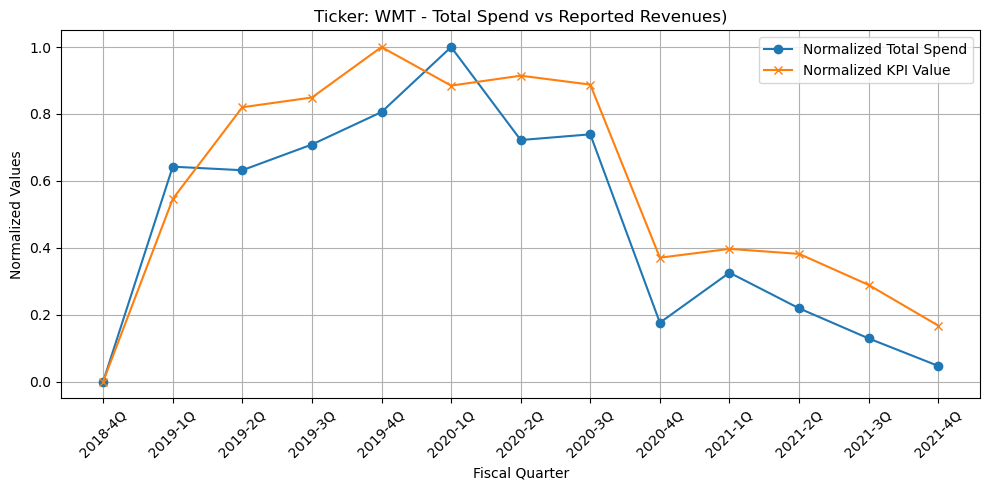

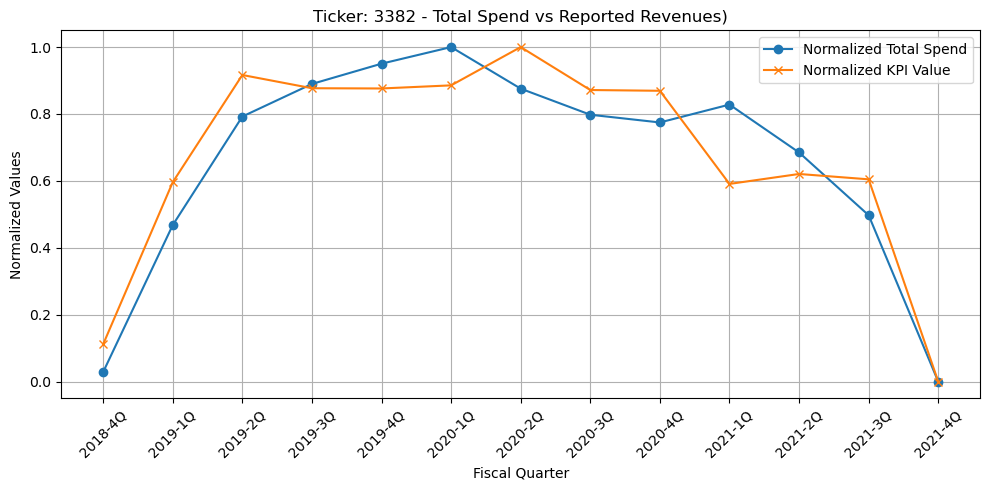

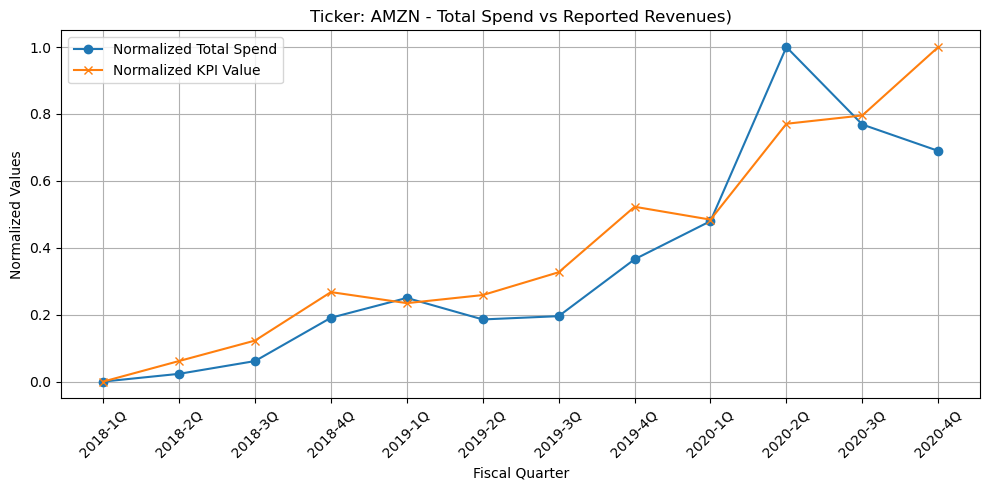

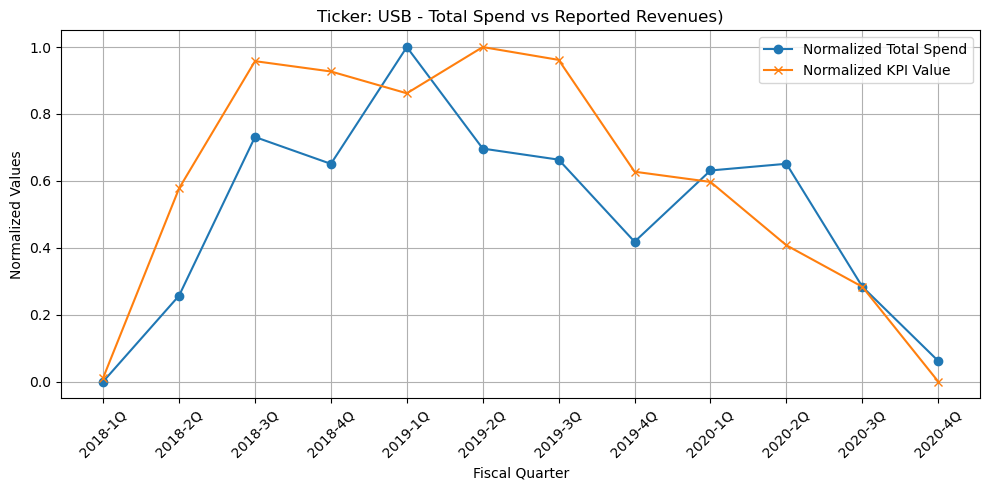

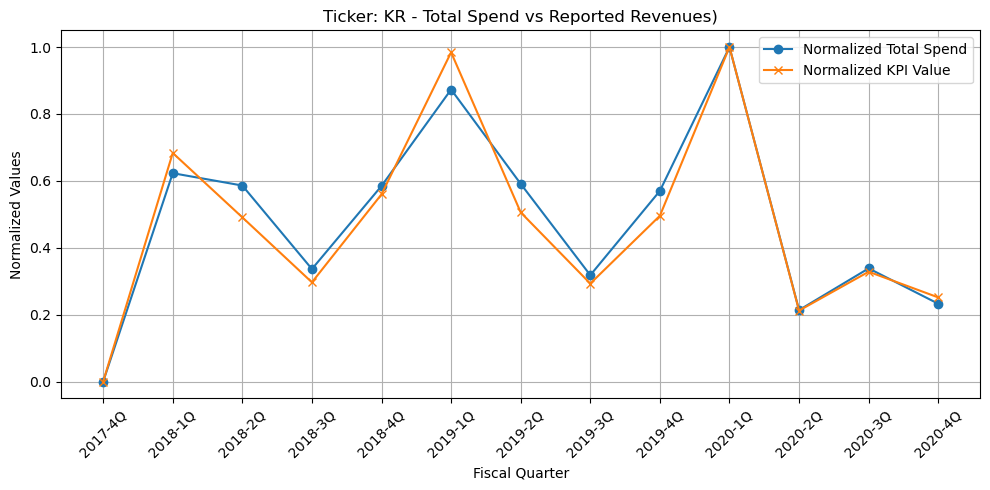

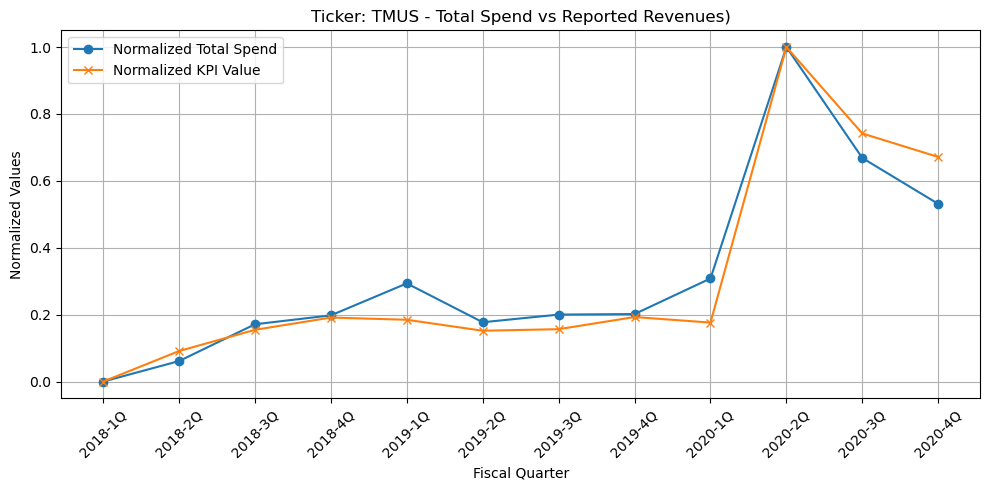

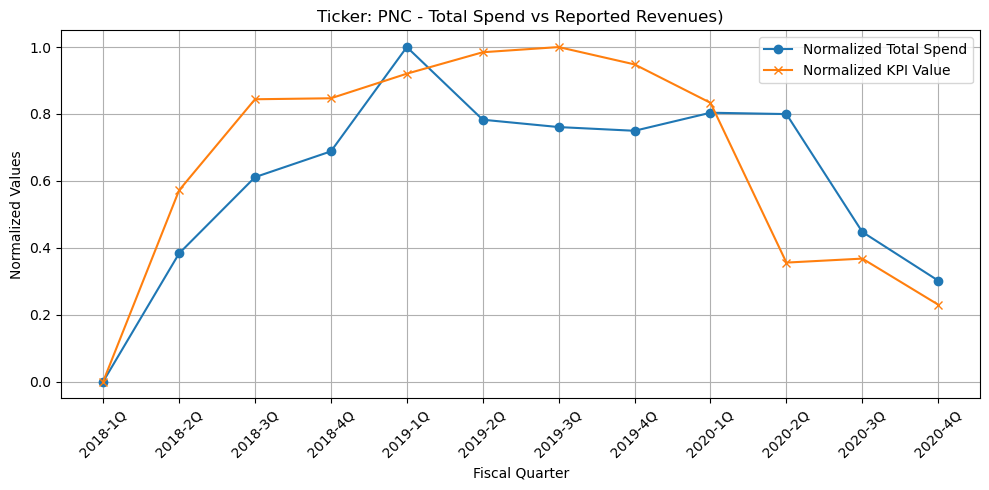

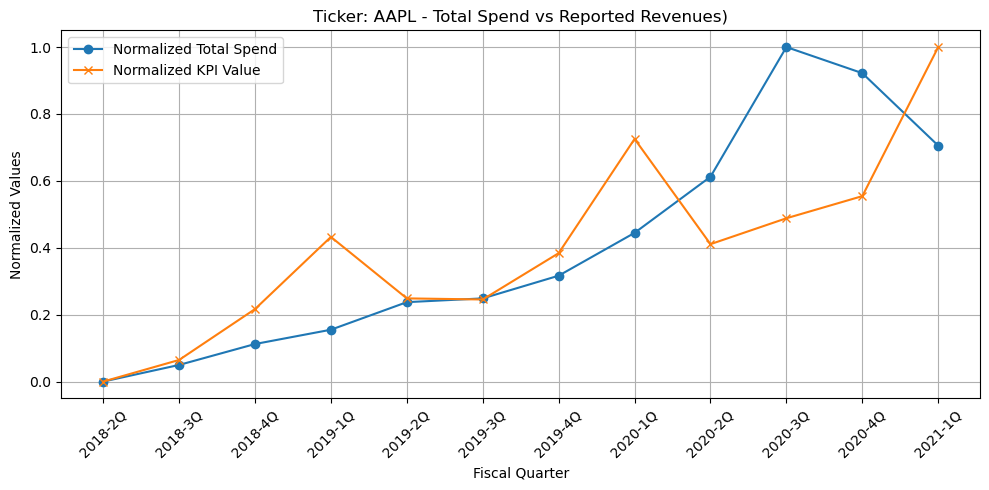

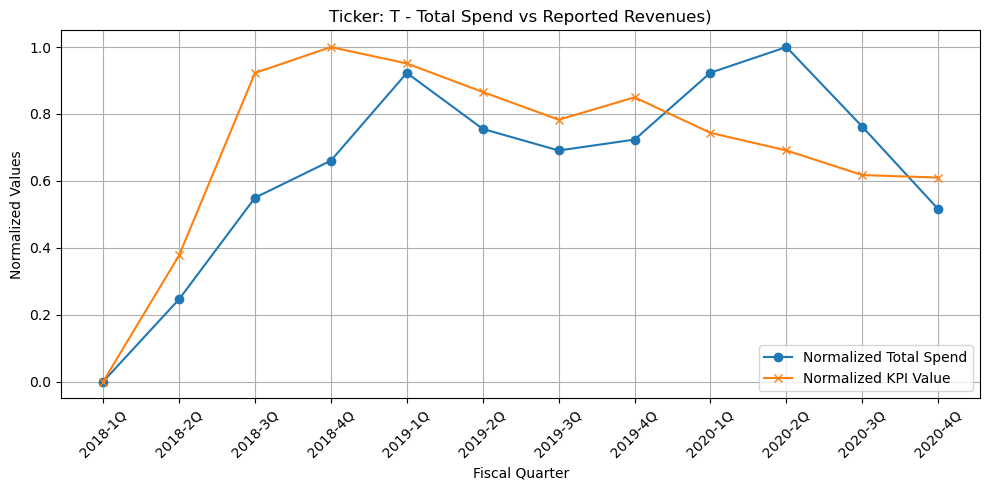

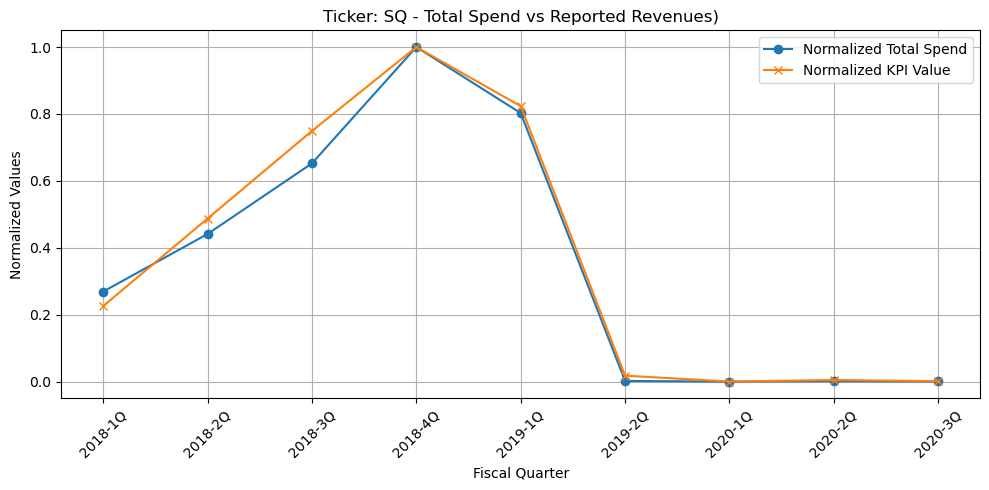

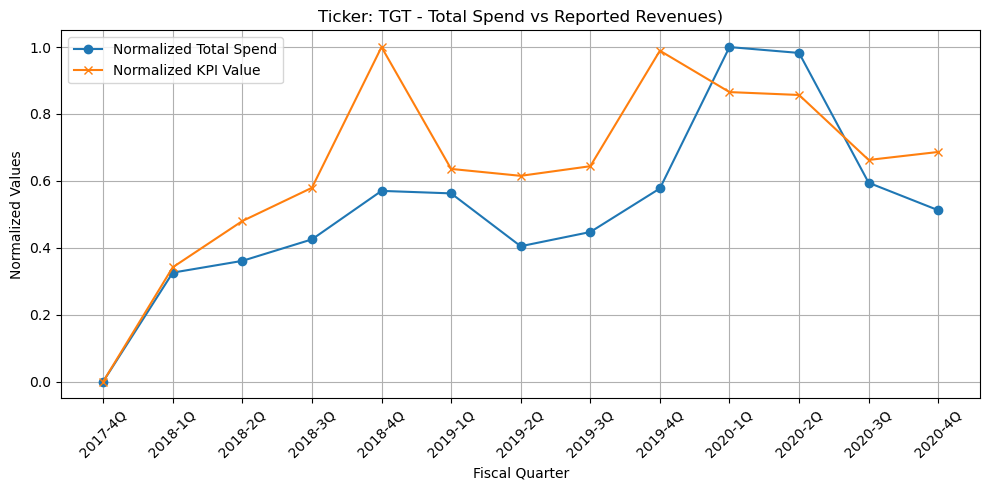

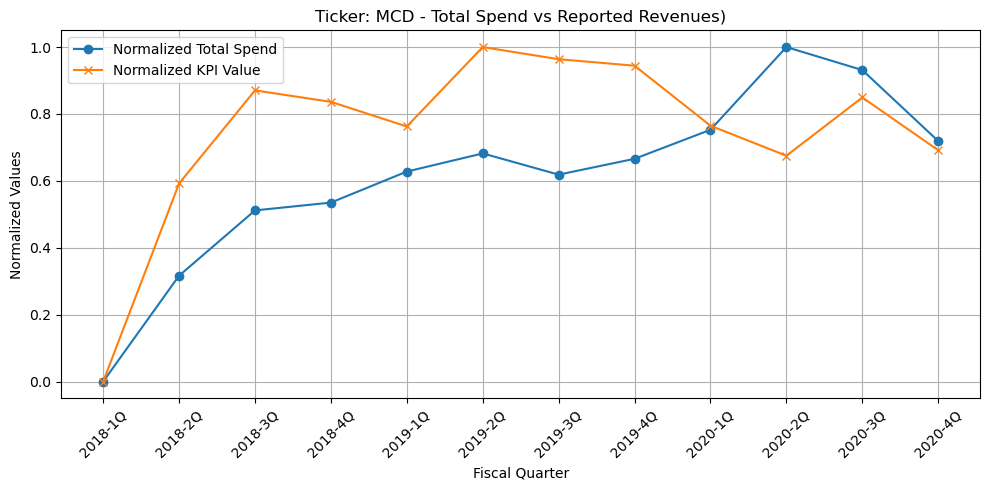

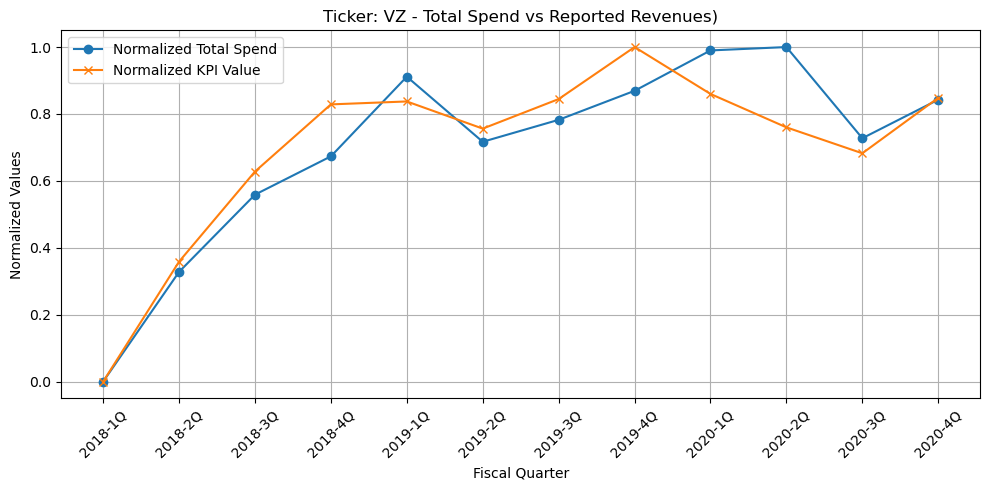

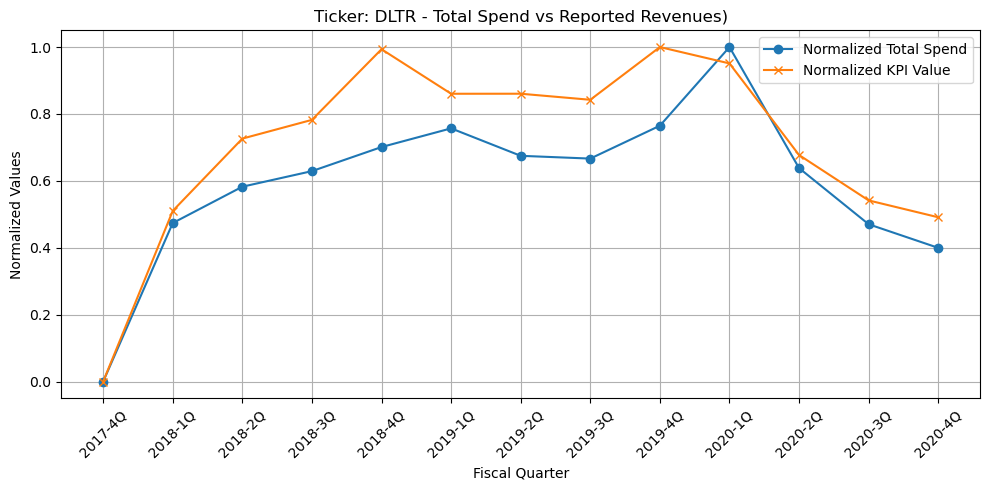

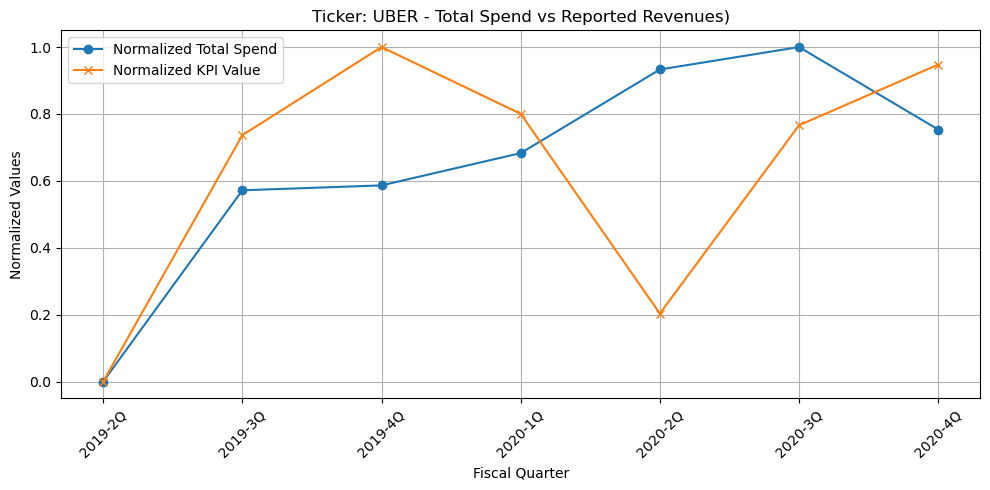

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Aggregate total spend and reported revenues at the ticker level per quarter
ticker_quarter_data = data_fiscal_revenue.groupby(['fiscal_quarter', 'merchant_ticker']).agg({
    'transactions': 'sum',
    'spend': 'sum',
    'kpivalue': 'sum'  
}).reset_index()

# Step 2: Find the top 15 companies by total spend
top_15_tickers = (
    ticker_quarter_data.groupby('merchant_ticker')['spend']
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .index
)

# Step 3: Filter data for only the top 15 tickers
top_15_data = ticker_quarter_data[ticker_quarter_data['merchant_ticker'].isin(top_15_tickers)]

# Step 4: Normalize spend and kpivalue data
top_15_data['normalized_spend'] = top_15_data.groupby('merchant_ticker')['spend'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)
top_15_data['normalized_kpivalue'] = top_15_data.groupby('merchant_ticker')['kpivalue'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Step 5: Calculate correlation coefficient for each ticker
correlation_results = (
    top_15_data.groupby('merchant_ticker')
    .apply(lambda x: np.corrcoef(x['spend'], x['kpivalue'])[0, 1])
    .reset_index(name='correlation')
)

# Print correlation coefficients
print(correlation_results)

# Step 6: Plot 15 line graphs
for ticker in top_15_tickers:
    ticker_data = top_15_data[top_15_data['merchant_ticker'] == ticker]
    plt.figure(figsize=(10, 5))
    plt.plot(
        ticker_data['fiscal_quarter'],
        ticker_data['normalized_spend'],
        label='Normalized Total Spend',
        marker='o'
    )
    plt.plot(
        ticker_data['fiscal_quarter'],
        ticker_data['normalized_kpivalue'],
        label='Normalized KPI Value',
        marker='x'
    )
    plt.title(f"Ticker: {ticker} - Total Spend vs Reported Revenues)")
    plt.xlabel("Fiscal Quarter")
    plt.ylabel("Normalized Values")
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



# Part 3

https://stock.walmart.com/financials/quarterly-results/default.aspx

We went to press release to see segment revenue for the segments we want are Walmart US and Sams Club, which is the walmart_revenues data that I manually entered. The code processes transaction and revenue data by standardizing fiscal quarters, filtering invalid entries, aggregating total spend per quarter, and merging it with Walmart's sales data to create a comparative dataset (comparison_data).

In [18]:
# Step 1: Manually input Walmart US and Sam's Club segment revenues for fiscal 2020
# Example data (replace with actual values from Walmart's quarterly reports)
walmart_revenues = pd.DataFrame({
    'fiscal_quarter': ['2020-Q1', '2020-Q2', '2020-Q3', '2020-Q4'],
    'walmart_us_sales': [80.3, 85.2, 83.2, 92.3],  # in billion dollars
    'sams_club_sales': [28.8, 29.1, 29.2, 15.3]  # in billion dollars
})
walmart_revenues['total_sales'] = walmart_revenues['walmart_us_sales'] + walmart_revenues['sams_club_sales']

# Standardize 'PERIOD_NAME_STANDARDIZED' to match 'fiscal_quarter'
data_fiscal['PERIOD_NAME_STANDARDIZED'] = data_fiscal['PERIOD_NAME_STANDARDIZED'].str.replace(
    r'(\d{4})-(\d)Q', r'\1-Q\2', regex=True
)

# Remove invalid entries (e.g., '-2019-4Q' or '-2021-1Q')
data_fiscal = data_fiscal[~data_fiscal['PERIOD_NAME_STANDARDIZED'].str.startswith('-')]


# Step 2: Merge with fiscal quarter mapping from Part 1
mapped_data = pd.merge(
    data_fiscal,
    walmart_revenues,
    left_on='PERIOD_NAME_STANDARDIZED',
    right_on='fiscal_quarter',
    how='inner'
)

# Step 3: Aggregate total spend per fiscal quarter
total_spend = mapped_data.groupby('PERIOD_NAME_STANDARDIZED')['spend'].sum().reset_index()
total_spend.rename(columns={'spend': 'total_spend'}, inplace=True)

# Step 4: Merge spend data with Walmart revenue data
comparison_data = pd.merge(
    total_spend,
    walmart_revenues[['fiscal_quarter', 'total_sales']],
    left_on='PERIOD_NAME_STANDARDIZED',
    right_on='fiscal_quarter',
    how='inner'
)

comparison_data

/var/folders/gr/wcm2f9z53x5290x9dmhnhjkh0000gn/T/ipykernel_10763/4108941111.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fiscal['PERIOD_NAME_STANDARDIZED'] = data_fiscal['PERIOD_NAME_STANDARDIZED'].str.replace(


,PERIOD_NAME_STANDARDIZED,total_spend,fiscal_quarter,total_sales
0,2020-Q1,22843735.89,2020-Q1,109.1
1,2020-Q2,22704742.94,2020-Q2,114.3
2,2020-Q3,21542541.65,2020-Q3,112.4
3,2020-Q4,19787895.79,2020-Q4,107.6


In [34]:
#Plotting two axes plot as the scales of total spend and total sales are different 

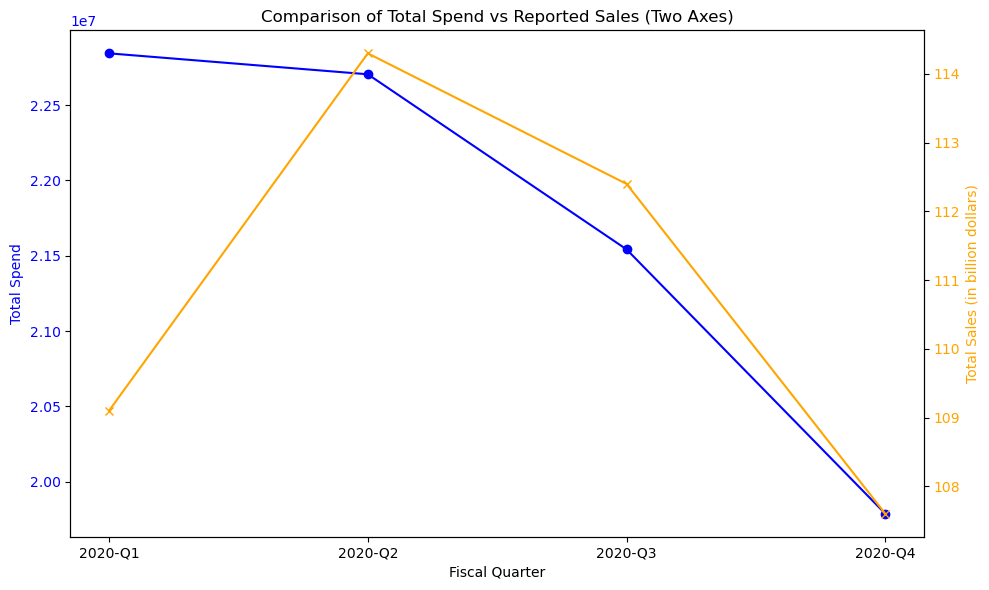

In [19]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot total spend on the left y-axis
ax1.set_xlabel('Fiscal Quarter')
ax1.set_ylabel('Total Spend', color='blue')
ax1.plot(comparison_data['fiscal_quarter'], comparison_data['total_spend'], marker='o', color='blue', label='Total Spend')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot total sales on the right y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Total Sales (in billion dollars)', color='orange')
ax2.plot(comparison_data['fiscal_quarter'], comparison_data['total_sales'], marker='x', color='orange', label='Total Sales')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Comparison of Total Spend vs Reported Sales (Two Axes)')
fig.tight_layout()
plt.show()


# Part 4

N/A

# Part 5

## Homework 2

Probability that if there is a spend value for a given month, the next month's spend value is missing: 0.027044253499536083
Probability that if a spend value is missing for a given month, the next month's spend value is also missing: 0.25282250601517675
0.047 of the data is in the test set
Imputing row 1/3593 with 1 missing, elapsed time: 2.217
Imputing row 101/3593 with 4 missing, elapsed time: 2.221
Imputing row 201/3593 with 3 missing, elapsed time: 2.226
Imputing row 301/3593 with 5 missing, elapsed time: 2.230
Imputing row 401/3593 with 5 missing, elapsed time: 2.235
Imputing row 501/3593 with 2 missing, elapsed time: 2.239
Imputing row 601/3593 with 4 missing, elapsed time: 2.243
Imputing row 701/3593 with 5 missing, elapsed time: 2.248
Imputing row 801/3593 with 4 missing, elapsed time: 2.252
Imputing row 901/3593 with 5 missing, elapsed time: 2.257
Imputing row 1001/3593 with 4 missing, elapsed time: 2.261
Imputing row 1101/3593 with 1 missing, elapsed time: 2.266
Imputing row 

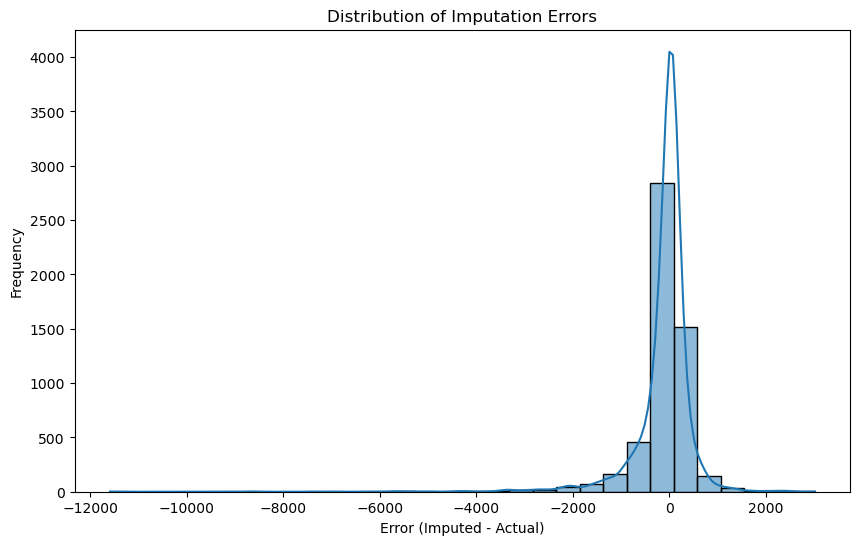

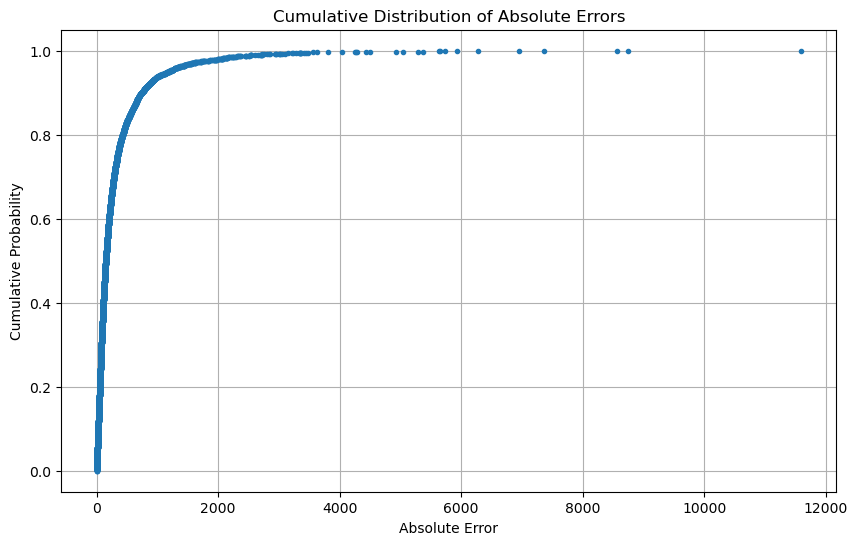

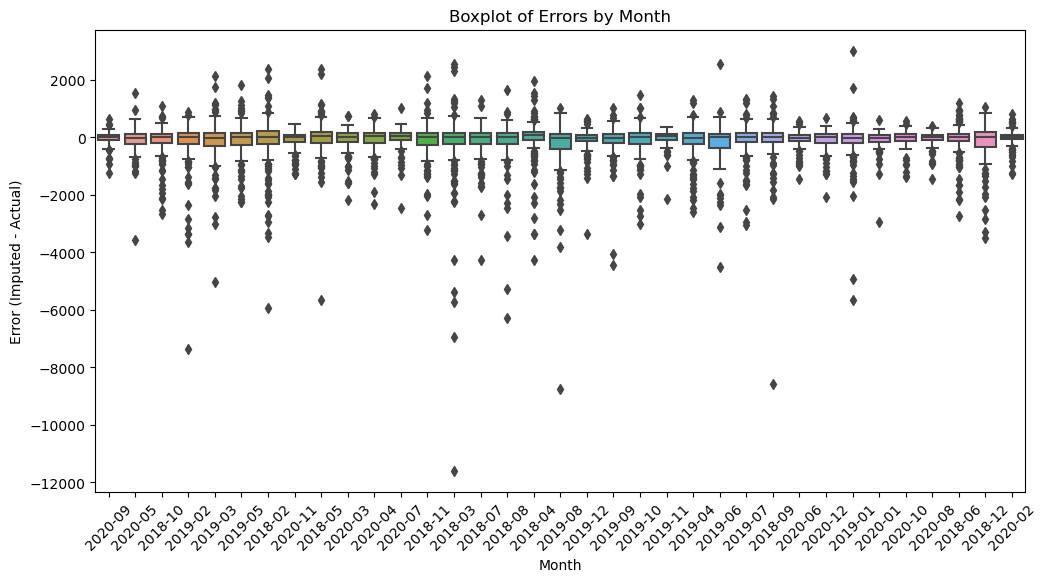

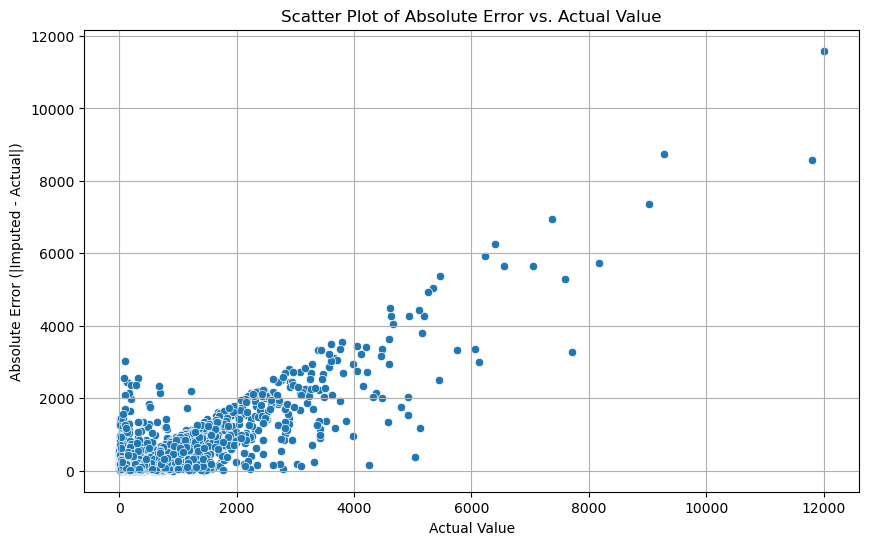

Accounts with the worst average errors:


account
a04:512:9BA2DEABDFCFB2E2CF377B03D655932B    3016.471660
a04:512:4F1C93D20E6BC0518AB2D437046D9593    1974.768857
a04:512:46FD7A7A7313C611A39ADF85AFD69F94    1644.892113
a04:512:9020C10242024FC30CE252E6AA216965    1594.810640
b01:44132:938654056                         1390.555077
a04:512:4C20A6783888736BA15E0C5159438677    1332.155757
a04:512:1D7659B35E7CAA20A5A384828DAF7C40    1266.359252
a04:512:FF8AC72DBFE6477366116DDC459A5527    1254.894377
a04:512:325C612BE60B1F751AAF387DD6D06ADF    1182.723121
a04:512:4173DEBBF98A8775E98782CDC92B8B4E    1147.822513
Name: error, dtype: float64

Imputing row 1/3593 with 0 missing, elapsed time: 1.922
Imputing row 101/3593 with 1 missing, elapsed time: 1.924
Imputing row 201/3593 with 1 missing, elapsed time: 1.926
Imputing row 301/3593 with 3 missing, elapsed time: 1.928
Imputing row 401/3593 with 3 missing, elapsed time: 1.930
Imputing row 501/3593 with 1 missing, elapsed time: 1.932
Imputing row 601/3593 with 4 missing, elapsed time: 1.934
Imputing row 701/3593 with 3 missing, elapsed time: 1.937
Imputing row 801/3593 with 3 missing, elapsed time: 1.939
Imputing row 901/3593 with 1 missing, elapsed time: 1.941
Imputing row 1001/3593 with 1 missing, elapsed time: 1.944
Imputing row 1101/3593 with 0 missing, elapsed time: 1.946
Imputing row 1201/3593 with 1 missing, elapsed time: 1.948
Imputing row 1301/3593 with 0 missing, elapsed time: 1.950
Imputing row 1401/3593 with 0 missing, elapsed time: 1.952
Imputing row 1501/3593 with 0 missing, elapsed time: 1.954
Imputing row 1601/3593 with 0 missing, elapsed time: 1.956
Imputing 

In [20]:
import pandas as pd
import numpy as np
from fancyimpute import KNN  # You can replace KNN with other methods in fancyimpute if needed
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Merchants specified in Part 5
merchants = ['WALMART', 'MCDONALDS', 'AMAZON', 'APPLE', 'WENDYS', 'TACO BELL', 'BURGER KING', 'DOLLAR GENERAL']

# Filter fiscal revenue for relevant merchants using their tickers
merchant_tickers = {
    'WALMART': 'WMT',
    'MCDONALDS': 'MCD',
    'AMAZON': 'AMZN',
    'APPLE': 'AAPL',
    'WENDYS': 'WEN',
    'TACO BELL': 'YUM',
    'BURGER KING': 'QSR',
    'DOLLAR GENERAL': 'DG'
}

data = data.loc[data['merchant_ticker'].isin(merchant_tickers.values())].copy()
data['Company'] = data['merchant_ticker'].map({v: k for k, v in merchant_tickers.items()})

threshold = 10
zscore_threshold = 3

# 1. Pivot data to user/month/total dollar spend
data['date'] = data['date'].dt.tz_localize(None)
data['month'] = data['date'].dt.to_period('M')
data_grouped = data.groupby(['account', 'month'])['spend'].sum()
pivot_data = data_grouped.unstack()
data_grouped = data_grouped.reset_index()
# data_grouped columns are ["account", "month", "spend"]

# Calculate the percentage of NaN values for each account
nan_percentage_by_account = pivot_data.isnull().sum(axis=1) / pivot_data.shape[1] * 100

# Remove accounts with more than 'threshold' % NaN values
filtered_pivot_data = pivot_data[nan_percentage_by_account <= threshold]

# Remove outliers at the user/month level using z-score on log(spend)
filtered_pivot_data_stacked = filtered_pivot_data.stack().reset_index()
filtered_pivot_data_stacked.columns = ['account', 'month', 'spend']
filtered_pivot_data_stacked['log_spend'] = np.log(filtered_pivot_data_stacked['spend'] + 1)  # Adding 1 to avoid log(0)
filtered_pivot_data_stacked['zscore'] = filtered_pivot_data_stacked.groupby('account')['log_spend'].transform(lambda x: zscore(x, nan_policy='omit'))
filtered_pivot_data_stacked = filtered_pivot_data_stacked[filtered_pivot_data_stacked['zscore'].abs() <= 3]

# Drop the zscore and log_spend columns as they are no longer needed
filtered_pivot_data_stacked = filtered_pivot_data_stacked.drop(columns=['zscore', 'log_spend'])

# Transform filtered_pivot_data_stacked back to have each row being an account and each month being a column
filtered_pivot_data = filtered_pivot_data_stacked.pivot(index='account', columns='month', values='spend')

# Calculate probabilities
# 1. Probability that if there is a spend value for a given month, the next month's spend value is missing
has_spend = filtered_pivot_data.notna()
missing_next_month = has_spend.shift(-1, axis=1).isna()
prob_spend_next_missing = (has_spend & missing_next_month).sum().sum() / has_spend.sum().sum()

# 2. Probability that if a spend value is missing for a given month, the next month's spend value is also missing
is_missing = filtered_pivot_data.isna()
missing_next_month_if_missing = is_missing.shift(-1, axis=1)
prob_missing_next_missing = (is_missing & missing_next_month_if_missing).sum().sum() / is_missing.sum().sum()

print(f"Probability that if there is a spend value for a given month, the next month's spend value is missing: {prob_spend_next_missing}")
print(f"Probability that if a spend value is missing for a given month, the next month's spend value is also missing: {prob_missing_next_missing}")

# Create a test set by removing data based on calculated probabilities
test_data = filtered_pivot_data.copy()
removed_values = []
for account in test_data.index:
    for month in test_data.columns[:-1]:  # Exclude the last month since there is no next month
        if pd.notna(test_data.at[account, month]):
            # Remove value with probability prob_spend_next_missing
            if random.random() < prob_spend_next_missing:
                test_data.at[account, month + 1] = np.nan
                removed_values.append((account, month + 1))
        elif pd.isna(test_data.at[account, month]):
            # Remove value with probability prob_missing_next_missing
            if random.random() < prob_missing_next_missing:
                test_data.at[account, month + 1] = np.nan
                removed_values.append((account, month + 1))

# Track removed values
removed_values_df = pd.DataFrame(removed_values, columns=['account', 'month'])

# Show percent of values in withholding set
print(f"{np.round(len(removed_values_df)/len(filtered_pivot_data_stacked), 3)} of the data is in the test set")
# The filtered data, test set, and probabilities are now ready for further analysis or modeling

# Impute the missing data in test_data using KNN
knn_imputer = KNN()
imputed_data = knn_imputer.fit_transform(test_data)
imputed_data_df = pd.DataFrame(imputed_data, index=test_data.index, columns=test_data.columns)

# Compare imputed values with actual values
comparison_results = []
for account, month in removed_values:
    actual_value = filtered_pivot_data.at[account, month]
    imputed_value = imputed_data_df.at[account, month]
    comparison_results.append({'account': account, 'month': month, 'actual_value': actual_value, 'imputed_value': imputed_value})

comparison_df = pd.DataFrame(comparison_results).dropna(subset=['actual_value'])
comparison_df['error'] = comparison_df['imputed_value'] - comparison_df['actual_value']
comparison_df['absolute_error'] = comparison_df['error'].abs()

# Plotting the distribution of errors
plt.figure(figsize=(10, 6))
sns.histplot(comparison_df['error'], bins=30, kde=True)
plt.xlabel('Error (Imputed - Actual)')
plt.ylabel('Frequency')
plt.title('Distribution of Imputation Errors')
plt.show()

# Cumulative Error Distribution
plt.figure(figsize=(10, 6))
sorted_errors = np.sort(np.abs(comparison_df['error']))
cdf = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
plt.plot(sorted_errors, cdf, marker='.', linestyle='none')
plt.xlabel('Absolute Error')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution of Absolute Errors')
plt.grid()
plt.show()

# Boxplot by Month
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='error', data=comparison_df)
plt.xlabel('Month')
plt.ylabel('Error (Imputed - Actual)')
plt.title('Boxplot of Errors by Month')
plt.xticks(rotation=45)
plt.show()

# Scatter plot showing how absolute error changes as actual value changes
plt.figure(figsize=(10, 6))
sns.scatterplot(x='actual_value', y='absolute_error', data=comparison_df)
plt.xlabel('Actual Value')
plt.ylabel('Absolute Error (|Imputed - Actual|)')
plt.title('Scatter Plot of Absolute Error vs. Actual Value')
plt.grid()
plt.show()

# Identify accounts with the worst errors
worst_accounts = comparison_df.groupby('account')['error'].mean().sort_values(ascending=False).head(10)
print("Accounts with the worst average errors:")
display(worst_accounts)

# Lastly apply imputation to whole dataset using KNN
knn_imputer = KNN()
imputed_data = knn_imputer.fit_transform(filtered_pivot_data)
imputed_data_df = pd.DataFrame(imputed_data, index=filtered_pivot_data.index, columns=filtered_pivot_data.columns)

/Users/srujithareddyambati/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Top 10 Merchants per Cluster:
cluster
0     [WALMART, AMAZON, MCDONALDS, DOLLAR GENERAL, A...
1     [WALMART, AMAZON, SAMS CLUB, MCDONALDS, APPLE ...
2     [WALMART, AMAZON, SAMS CLUB, MCDONALDS, APPLE,...
3     [WALMART, AMAZON, MCDONALDS, DOLLAR GENERAL, A...
4     [WALMART, AMAZON, MCDONALDS, APPLE, DOLLAR GEN...
5     [WALMART, AMAZON, SAMS CLUB, MCDONALDS, TACO B...
6     [WALMART, AMAZON, SAMS CLUB, MCDONALDS, DOLLAR...
7     [WALMART, AMAZON, APPLE PAY, MCDONALDS, DOLLAR...
8     [WALMART, AMAZON, MCDONALDS, SAMS CLUB, DOLLAR...
9     [WALMART, AMAZON, WENDYS, MCDONALDS, APPLE, AP...
10    [WALMART, AMAZON, MCDONALDS, DOLLAR GENERAL, A...
11    [WALMART, AMAZON, APPLE, MCDONALDS, APPLE PAY,...
12    [APPLE PAY, AMAZON, WALMART, APPLE, SAMS CLUB,...
13    [WALMART, AMAZON, APPLE PAY, MCDONALDS, DOLLAR...
14    [APPLE PAY, AMAZON, WALMART, SAMS CLUB, APPLE,...
dtype: object

Total Number of Users per Cluster:
11    3307
4     2138
0     1547
10    1007
3      635
8      453
6     

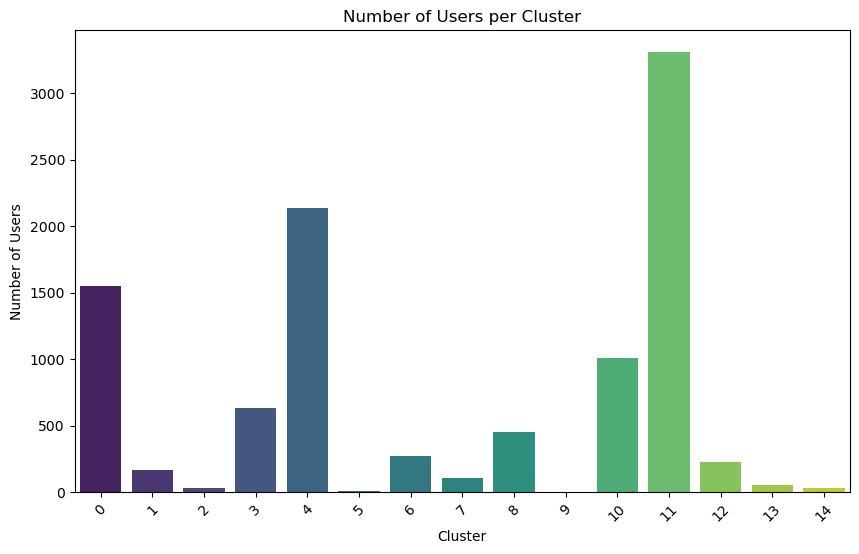

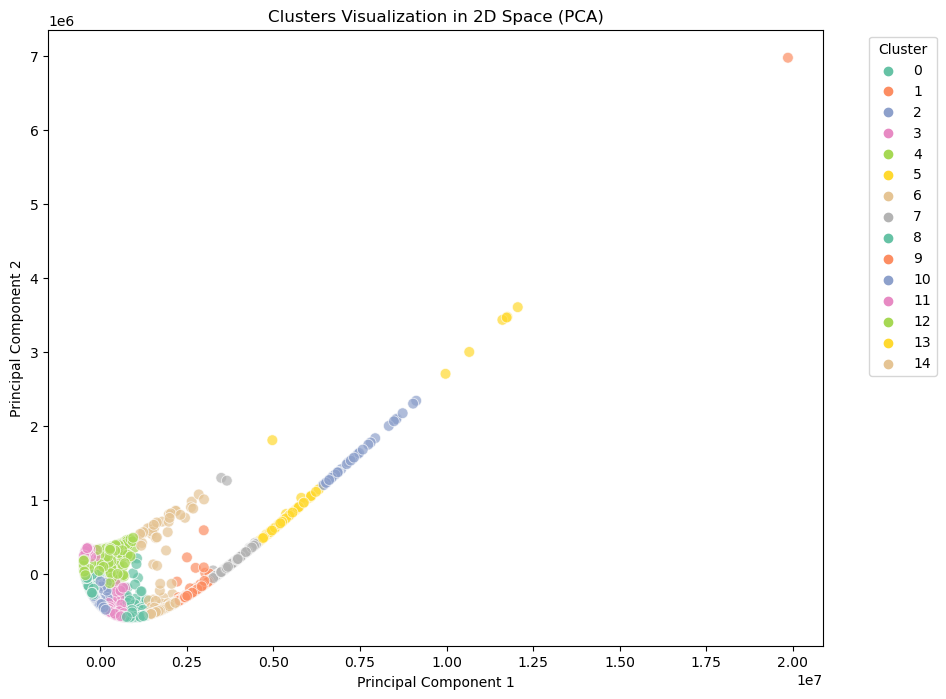

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Prepare data for clustering
# Aggregate by account and merchant to get total spend by each user at each merchant
merchant_spend = data.groupby(['account', 'merchant'])['spend'].sum().unstack(fill_value=0)

# 1. Distance Metric 1: TF-IDF on merchants
merchant_strings = data.groupby('account')['merchant_string_example'].apply(lambda x: ' '.join(map(str, x))).reset_index()
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(merchant_strings['merchant_string_example'])
tfidf_similarity = cosine_similarity(tfidf_matrix)

# 2. Distance Metric 2: Euclidean distance on spending patterns across merchants
euclidean_distance = euclidean_distances(merchant_spend)

# 3. Clustering using KMeans on chosen metric (e.g., Euclidean distance)
kmeans = KMeans(n_clusters=15, random_state=42)
clusters = kmeans.fit_predict(euclidean_distance)

# Assign clusters to accounts and analyze top merchants per cluster
merchant_spend['cluster'] = clusters
top_merchants_per_cluster = merchant_spend.groupby('cluster').sum().apply(lambda x: x.nlargest(10).index.tolist(), axis=1)

# Count users per cluster
users_per_cluster = merchant_spend['cluster'].value_counts()

# Display the results
print("Top 10 Merchants per Cluster:")
print(top_merchants_per_cluster)
print("\nTotal Number of Users per Cluster:")
print(users_per_cluster)

# 1. Bar Chart: Number of Users per Cluster
plt.figure(figsize=(10, 6))
sns.barplot(x=users_per_cluster.index, y=users_per_cluster.values, palette='viridis')
plt.xlabel('Cluster')
plt.ylabel('Number of Users')
plt.title('Number of Users per Cluster')
plt.xticks(rotation=45)
plt.show()

# 2. PCA for Visualization in 2D Space
# Reduce the dimensions of the spending patterns for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(euclidean_distance)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters

# Scatter plot to visualize clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set2', s=60, alpha=0.7)
plt.title('Clusters Visualization in 2D Space (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [22]:
account_cluster_map = merchant_spend.reset_index()#['index', 'cluster']

In [23]:
account_cluster_map = account_cluster_map[['account', 'cluster']]

In [24]:
data_cluster = data.merge(account_cluster_map, left_on='account', right_on='account')

In [25]:
cluster_spend = data_cluster.groupby(['cluster', 'fiscal_quarter']).agg({'spend': 'sum'}).reset_index()

In [26]:
cluster_spend_pivot = cluster_spend.pivot(index='cluster', columns='fiscal_quarter', values='spend')
cluster_spend_pivot = cluster_spend_pivot.fillna(0)

In [27]:
cluster_spend_pivot

fiscal_quarter,2017-4Q,2018-1Q,2018-2Q,2018-3Q,2018-4Q,2019-1Q,2019-2Q,2019-3Q,2019-4Q,2020-1Q,2020-2Q,2020-3Q,2020-4Q,2021-1Q,2021-2Q,2021-3Q,2021-4Q
cluster,,,,,,,,,,,,,,,,,
0,5190.27,144910.80,193300.35,233793.43,486869.83,1527038.28,1527435.57,1536296.72,1769372.89,2095809.89,1868153.20,1841620.87,1009158.14,915086.75,689317.63,491360.20,341788.47
1,1504.45,24997.49,28505.35,35391.36,208704.33,773356.29,756648.70,834437.85,993403.30,1202260.70,932451.69,945920.40,356870.56,327276.34,212247.96,180074.26,124134.58
2,130.69,3098.93,5370.73,7533.82,54654.89,256763.87,336693.37,399294.11,435365.48,446727.99,383776.93,371722.65,112156.09,128191.04,86137.84,67829.02,47343.30
3,3741.44,80885.45,101937.23,116578.18,331456.62,1301288.05,1279266.21,1298491.29,1489828.99,1888504.30,1425876.68,1485834.86,651214.73,735602.31,507325.19,398740.62,269974.45
4,5375.24,158098.02,238058.73,266147.99,483694.04,1210092.37,1237109.16,1251734.16,1453760.38,1642417.52,1579600.28,1538482.81,940071.16,806045.09,584367.81,382415.07,285712.58
5,0.00,1528.04,1262.25,2671.49,16792.11,63685.93,94267.87,99302.58,121826.92,122277.22,115054.12,111078.16,38577.03,34784.79,17788.03,25113.70,17720.92
6,1726.90,42065.40,53707.85,58002.64,238120.28,1055299.97,949859.62,1108052.50,1168580.57,1350176.76,1081225.14,1125926.47,463358.73,481169.80,298133.22,267476.22,170724.13
7,324.70,17990.61,21013.73,25181.05,142861.77,630955.75,604985.43,677070.29,739137.04,969262.57,726951.62,735083.14,259842.76,289904.62,177640.08,150149.45,90153.63
8,1626.11,58317.33,76996.59,91360.40,281585.98,1355071.76,1166860.88,1271332.12,1359202.56,1899895.22,1472754.41,1386290.94,559012.74,637381.97,451895.89,331090.51,202161.70


In [28]:
company_revenue = data.groupby(['Company', 'fiscal_quarter']).agg({'kpivalue': 'sum'}).reset_index()
company_revenue_pivot = company_revenue.pivot(index='Company', columns='fiscal_quarter', values='kpivalue')

In [29]:
company_revenue_pivot

fiscal_quarter,2017-4Q,2018-1Q,2018-2Q,2018-3Q,2018-4Q,2019-1Q,2019-2Q,2019-3Q,2019-4Q,2020-1Q,2020-2Q,2020-3Q,2020-4Q,2021-1Q,2021-2Q,2021-3Q,2021-4Q
Company,,,,,,,,,,,,,,,,,
AMAZON,NaN,1.484325e+08,2.057208e+08,2.626592e+08,3.976896e+08,3.669298e+08,3.894290e+08,4.529861e+08,6.354410e+08,5.995587e+08,8.666310e+08,8.898232e+08,1.080311e+09,NaN,NaN,NaN,NaN
APPLE,NaN,NaN,2.651512e+08,3.342911e+08,4.970358e+08,7.278482e+08,5.312434e+08,5.277587e+08,6.759422e+08,1.041319e+09,7.047126e+08,7.875436e+08,8.583484e+08,1.335151e+09,NaN,NaN,NaN
DOLLAR GENERAL,5155933.068,2.116512e+07,3.069185e+07,3.275321e+07,3.364445e+07,3.465066e+07,3.749362e+07,3.665013e+07,3.746502e+07,4.197775e+07,3.763863e+07,3.136339e+07,2.377769e+07,NaN,NaN,NaN,NaN
MCDONALDS,NaN,8.255552e+07,1.261142e+08,1.465866e+08,1.440717e+08,1.386494e+08,1.561166e+08,1.534489e+08,1.520148e+08,1.388195e+08,1.322185e+08,1.450269e+08,1.334211e+08,NaN,NaN,NaN,NaN
TACO BELL,NaN,9.584661e+06,1.272787e+07,1.522310e+07,1.739819e+07,1.482103e+07,1.520255e+07,1.481202e+07,1.788525e+07,1.392584e+07,1.373148e+07,1.475222e+07,1.550921e+07,NaN,NaN,NaN,NaN
WALMART,NaN,NaN,NaN,NaN,5.395018e+08,2.151181e+09,2.960331e+09,3.046413e+09,3.491562e+09,3.151272e+09,3.238867e+09,3.160312e+09,1.632735e+09,1.710433e+09,1.666483e+09,1.392532e+09,1.033450e+09
WENDYS,NaN,4.434167e+06,6.034005e+06,6.954212e+06,6.990765e+06,7.641680e+06,7.447872e+06,7.708514e+06,7.486805e+06,7.425491e+06,6.584610e+06,7.010164e+06,6.480442e+06,NaN,NaN,NaN,NaN


In [30]:
from fancyimpute import KNN

knn_imputer = KNN(orientation='columns')
imputed_data = knn_imputer.fit_transform(company_revenue_pivot)
imputed_data_df = pd.DataFrame(imputed_data, index=company_revenue_pivot.index, columns=company_revenue_pivot.columns)

company_revenue_pivot = imputed_data_df.reset_index()

knn_imputer = KNN(orientation='columns')
imputed_data = knn_imputer.fit_transform(cluster_spend_pivot)
imputed_data_df = pd.DataFrame(imputed_data, index=cluster_spend_pivot.index, columns=cluster_spend_pivot.columns)

cluster_spend_pivot = imputed_data_df.reset_index()

Imputing row 1/17 with 6 missing, elapsed time: 0.001
Imputing row 1/17 with 0 missing, elapsed time: 0.000


/Users/srujithareddyambati/anaconda3/lib/python3.11/site-packages/fancyimpute/solver.py:55: UserWarning: Input matrix is not missing any values
  warnings.warn("Input matrix is not missing any values")


In [31]:
cluster_spend_pivot = cluster_spend_pivot[['cluster', 
                                           '2018-2Q',
                                           '2018-3Q',
                                           '2018-4Q',
                                           '2019-1Q',
                                           '2019-2Q',
                                           '2019-3Q',
                                           '2019-4Q',
                                           '2020-1Q',
                                           '2020-2Q',
                                           '2020-3Q',
                                           '2020-4Q',
                                          ]]

company_revenue_pivot = company_revenue_pivot[['Company', 
                                               '2018-2Q',
                                               '2018-3Q',
                                               '2018-4Q',
                                               '2019-1Q',
                                               '2019-2Q',
                                               '2019-3Q',
                                               '2019-4Q',
                                               '2020-1Q',
                                               '2020-2Q',
                                               '2020-3Q',
                                               '2020-4Q']]

#### Part 5 - notes: This code implements a constrained regression model to map clusters (spending data) to companies (revenue data) on a per-quarter basis, using a Mean Absolute Percentage Error (MAPE) loss function. It normalizes the input (spend) and output (revenue) data, optimizes weights for the regression using the L-BFGS-B method under specific bounds, and rescales predictions back to the original scale. Finally, it evaluates the model's performance by calculating the rescaled MAPE for training data.

In [32]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Align columns (fiscal quarters) between the two datasets
common_columns = set(cluster_spend_pivot.columns[1:]).intersection(company_revenue_pivot.columns[1:])
cluster_spend_pivot = cluster_spend_pivot[['cluster'] + list(common_columns)]
company_revenue_pivot = company_revenue_pivot[['Company'] + list(common_columns)]

# Fill missing values with zeros
cluster_spend_pivot_filled = cluster_spend_pivot.fillna(0)
company_revenue_pivot_filled = company_revenue_pivot.fillna(0)

# Extract numeric data
X = cluster_spend_pivot_filled.iloc[:, 1:].values  # Exclude 'cluster' column
y = company_revenue_pivot_filled.iloc[:, 1:].values  # Exclude 'Company' column

# Normalize inputs (X) and outputs (y)
input_scaler = StandardScaler() #MinMaxScaler()
output_scaler = StandardScaler() #MinMaxScaler()

X_normalized = input_scaler.fit_transform(X)
y_normalized = output_scaler.fit_transform(y.T).T  # Normalize each company's data

# Define the constrained regression function
def constrained_regression_improved(X, y):
    """
    Perform regression quarter by quarter, mapping clusters (rows of X) to companies (rows of y),
    """
    n_clusters, n_quarters = X.shape
    n_companies = y.shape[0]

    optimized_weights = []

    for i in range(n_quarters):
        # Extract the ith column for regression (single fiscal quarter)
        X_col = X[:, i].reshape(-1, 1)  # (15, 1)
        y_col = y[:, i]  # (7,)

        # Define the objective function: minimize MAPE
        def mape_loss(weights, X_col, y_col):
            weights = weights.reshape(-1, n_companies)  # Reshape weights to (15, 7)
            predictions = X_col.T @ weights  # Weighted sum: (1, 15) x (15, 7) = (1, 7)
            mape = np.mean(np.abs((y_col - predictions.flatten()) / (np.maximum(y_col, 1e-3))))  # Adjust denominator
            return mape

        # Constraints: weights must lie within 0 to 10 (wider range for normalized data)
        bounds = [(1, 15) for _ in range(n_clusters * n_companies)]

        # Initial weights
        initial_weights = np.random.uniform(0, 10, size=n_clusters * n_companies)

        # Minimize MAPE
        result = minimize(
            fun=mape_loss,
            x0=initial_weights,
            args=(X_col, y_col),
            bounds=bounds,
            method="L-BFGS-B",
        )

        # Reshape weights for the current quarter and append
        optimized_weights.append(result.x.reshape(n_clusters, n_companies))

    # Return the optimized weights for all quarters
    return np.array(optimized_weights)  # Shape: (n_quarters, n_clusters, n_companies)

# Fit the constrained regression model
optimized_weights_normalized = constrained_regression_improved(X_normalized, y_normalized)

# Make predictions on normalized data
predictions_normalized = np.array([
    (X_normalized[:, i].reshape(-1, 1).T @ optimized_weights_normalized[i]).flatten()
    for i in range(X_normalized.shape[1])
]).T

# Rescale predictions back to the original scale
predictions_rescaled = np.abs(output_scaler.inverse_transform(predictions_normalized.T).T)

# Calculate MAPE on the rescaled predictions
mape_train_rescaled = np.mean(np.abs((y - predictions_rescaled) / (y + 1e-3))) * 100

# Display the results
print("Final Training MAPE (Rescaled):", mape_train_rescaled)
print("Optimized Weights Shape:", optimized_weights_normalized.shape)


Final Training MAPE (Rescaled): 37.048975498220194
Optimized Weights Shape: (11, 15, 7)


In [33]:
optimized_weights_normalized

array([[[7.74721067, 3.02600911, 7.95339744, ..., 6.82394123,
         8.39949985, 5.60313591],
        [3.35714029, 5.71062088, 4.82328368, ..., 2.03980088,
         4.29270207, 4.00384986],
        [2.16634227, 5.02141854, 9.34180235, ..., 6.72829853,
         2.59233038, 2.97031449],
        ...,
        [3.93648941, 6.96340298, 4.68464797, ..., 8.77364402,
         1.58535364, 4.74358624],
        [5.30036321, 5.71429199, 7.2138328 , ..., 1.10925995,
         5.25064587, 4.85929701],
        [1.96250289, 5.80559756, 7.50342434, ..., 8.56967934,
         7.63617031, 9.03633649]],

       [[8.50340327, 2.5973499 , 4.92294004, ..., 1.88100584,
         4.74356269, 8.14582285],
        [7.30229723, 8.24287033, 7.71305906, ..., 5.60801036,
         4.93978927, 1.30551113],
        [5.42826744, 7.53892191, 5.4925407 , ..., 8.56747893,
         7.77757568, 4.40874681],
        ...,
        [5.32006344, 6.68739253, 1.00085649, ..., 5.91182286,
         6.12977641, 5.01929446],
        [8.5